> ## Utils

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_path = "./Images/{}"

In [3]:
def read_image(path, cvtcolor="RGB", cvtfloat=False):
    if cvtcolor == "RGB":
        if cvtfloat:
            return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2RGB)
    elif cvtcolor == "GRAY":
        if cvtfloat:
            return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
        return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2GRAY)

def write_image(image, path):
    if not os.path.exists(path):
        os.mkdir(path)
    cv2.imwrite(path, image)

def show_image(image, cmap=None, title=None):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [4]:
def conv2D(image: np.ndarray, filter_kernel: np.ndarray) -> np.ndarray:
    height, width = image.shape[0], image.shape[1]
    k = filter_kernel.shape[0]
    pad_size = k // 2
    
    # Pads image with the edge values of array.
    image_tmp = np.pad(image, pad_size, mode="edge")

    # Initialize an empty destination image
    dst = np.zeros((height, width))

    # Perform convolution
    for i in range(height):
        for j in range(width):
            roi = image_tmp[i:i+k, j:j+k]
            dst[i, j] = np.sum(roi * filter_kernel)

    return dst

In [5]:
def meanFilter(image: np.ndarray, kernel_size: int, timing: bool = False) -> np.ndarray:
    assert kernel_size >= 1
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    
    start = time.time()
    filtered_image = conv2D(image, kernel)
    end = time.time()
    if timing:
        return filtered_image, end - start
    
    return filtered_image

In [6]:
def im2col(image: np.ndarray, block_size: tuple) -> np.ndarray:
    rows, cols = image.shape
    dst_height = cols - block_size[1] + 1
    dst_width = rows - block_size[0] + 1
    image_array = np.zeros((dst_height * dst_width, block_size[1] * block_size[0]))
    row = 0
    for i in range(dst_height):
        for j in range(dst_width):
            window = np.ravel(image[i : i + block_size[0], j : j + block_size[1]])
            image_array[row, :] = window
            row += 1

    return image_array

def speedyConv2D(image: np.ndarray, filter_kernel: np.ndarray) -> np.ndarray:
    height, width = image.shape[0], image.shape[1]
    k = filter_kernel.shape[0]
    pad_size = k // 2
    
    # Pads image with the edge values of array.
    image_tmp = np.pad(image, pad_size, mode="edge")

    image_array = im2col(image_tmp, (k, k)) # Convert image to required size

    kernel_array = np.ravel(filter_kernel) # Flatten the kernel
    dst = np.dot(image_array, kernel_array).reshape(height, width) # Perform convolution

    return dst

def speedyMeanFilter(image: np.ndarray, kernel_size: int, timing: bool = False) -> np.ndarray:
    assert kernel_size >= 1
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    
    start = time.time()
    filtered_image = speedyConv2D(image, kernel)
    end = time.time()
    if timing:
        return filtered_image, end - start
    
    return filtered_image

In [7]:
def superSpeedyConv(image, half_kernel):
    height, width = image.shape[0], image.shape[1]
    
    integral_img = np.cumsum(np.cumsum(image, axis=0), axis=1)
    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(height):
        for j in range(width):
            x1, y1 = max(0, i - half_kernel), max(0, j - half_kernel)
            x2, y2 = min(height - 1, i + half_kernel), min(width - 1, j + half_kernel)

            count = (x2 - x1 + 1) * (y2 - y1 + 1)
            sum_region = integral_img[x2, y2] - integral_img[x1 - 1, y2] - integral_img[x2, y1 - 1] + integral_img[x1 - 1, y1 - 1]

            filtered_image[i, j] = sum_region / count
    
    return filtered_image

def superSpeedyMeanFilter(image: np.ndarray, kernel_size: int, timing: bool = False) -> np.ndarray:
    assert kernel_size >= 1
    height, width = image.shape
    half_kernel = kernel_size // 2

    start = time.time()
    filtered_image = superSpeedyConv(image, half_kernel)
    end = time.time()

    if timing:
        return filtered_image, end - start

    return filtered_image

In [8]:
def gen_gaussian_kernel(k, sigma):
    center = k // 2
    x, y = np.mgrid[0 - center : k - center, 0 - center : k - center]
    g = 1 / (2 * np.pi * sigma) * np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(sigma)))
    return g

def gaussianFilter(image: np.ndarray, kernel_size: int, sigma: float, timing: bool = False) -> np.ndarray:
    assert kernel_size >= 1
    kernel = gen_gaussian_kernel(kernel_size, sigma)
    
    start = time.time()
    filtered_image = conv2D(image, kernel)
    end = time.time()
    if timing:
        return filtered_image, end - start
    
    return filtered_image

> ## Main Code

#### 1. Convolution

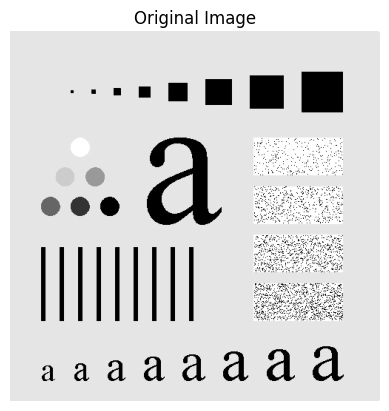

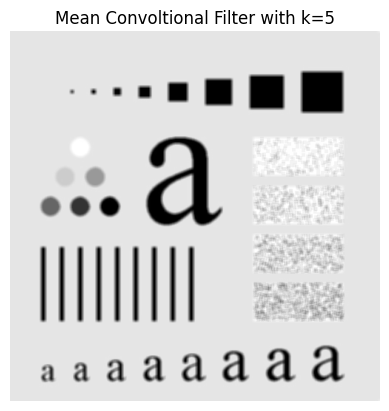

Time taken for mean filter: 1.2789 seconds


In [53]:
img1 = read_image("testPattern.jpg", cvtcolor="GRAY", cvtfloat=True)
mf, timing = meanFilter(img1, kernel_size=5, timing=True)

show_image(img1, cmap="gray", title="Original Image")
show_image(mf, cmap="gray", title="Mean Convoltional Filter with k=5")
print("Time taken for mean filter: {:.4f} seconds".format(timing))

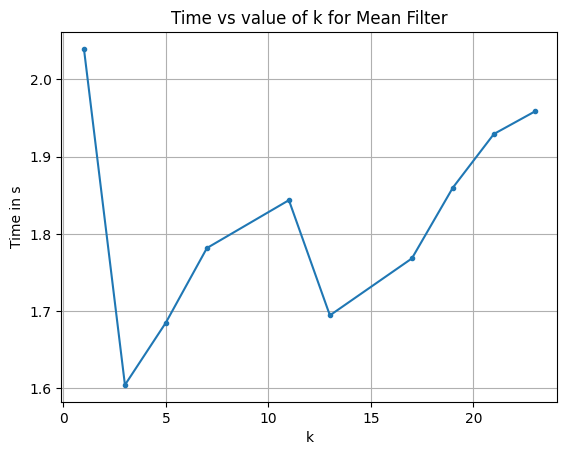

In [34]:
timings = list()
ks = [1,3,5,7,11,13,17,19,21,23]

for k in ks:
    _, timing = meanFilter(img1, kernel_size=k, timing=True)
    timings.append(timing)

plt.plot(ks, timings, marker=".")
plt.xlabel("k")
plt.ylabel("Time in s")
plt.title("Time vs value of k for Mean Filter")
plt.grid(True)
plt.show()

> **Impact on Time with different kernel size**

Larger kernel sizes mean more calculations are needed for each pixel in the output image. Specifically, the time complexity of a convolution operation is `O(k^2 * M * N)`, where:

`k` is the size of the kernel (both height and width).
`M` is the height of the input image.
`N` is the width of the input image.

Impact of kernel size on time complexity is quadratic. So, if you double the kernel size, you quadruple the time it takes to run the convolution operation.

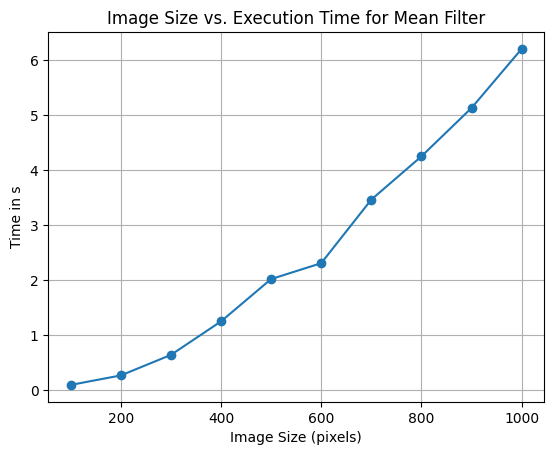

In [35]:
timings = list()
image_sizes = range(100, 1100, 100)

for size in image_sizes:
    random_image = np.random.rand(size, size)
    _, timing = meanFilter(random_image, kernel_size=5, timing=True)
    timings.append(timing)

plt.plot(image_sizes, timings, marker='o')
plt.title('Image Size vs. Execution Time for Mean Filter')
plt.xlabel('Image Size (pixels)')
plt.ylabel('Time in s')
plt.grid(True)
plt.show()

> **Impact on Time with different Image size**

Larger image sizes mean more calculations are needed for each pixel in the output image. Specifically, the time complexity of a convolution operation is `O(k^2 * M * N)`, where:

`k` is the size of the kernel (both height and width).
`M` is the height of the input image.
`N` is the width of the input image.

The impact of image dimensions (h and w) on computation time is linear. Doubling the dimensions will approximately double the time taken for convolution.

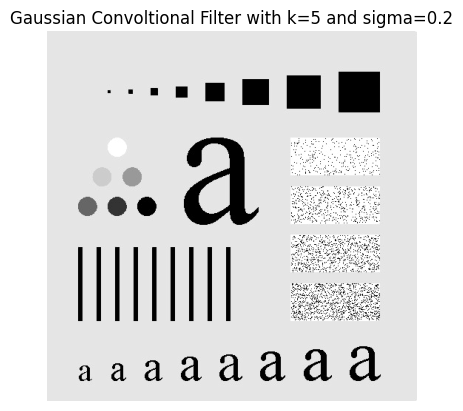

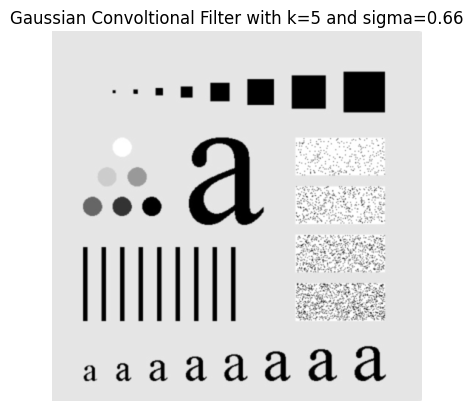

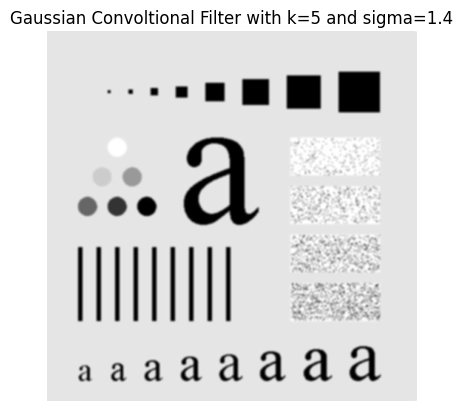

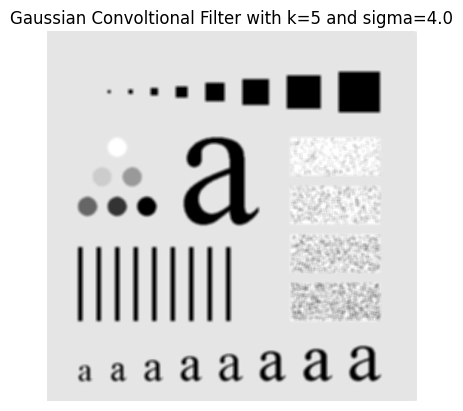

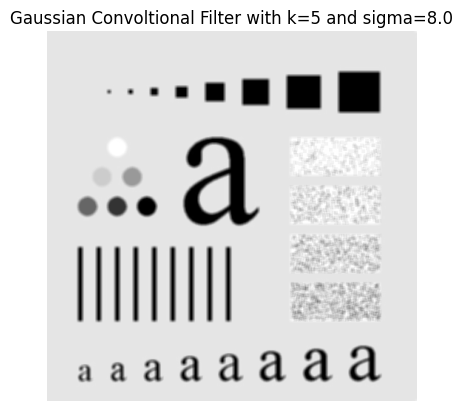

In [36]:
show_image(gaussianFilter(img1, kernel_size=5, sigma=0.2), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=0.2")
show_image(gaussianFilter(img1, kernel_size=5, sigma=0.66), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=0.66")
show_image(gaussianFilter(img1, kernel_size=5, sigma=1.4), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=1.4")
show_image(gaussianFilter(img1, kernel_size=5, sigma=4.0), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=4.0")
show_image(gaussianFilter(img1, kernel_size=5, sigma=8.0), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=8.0")

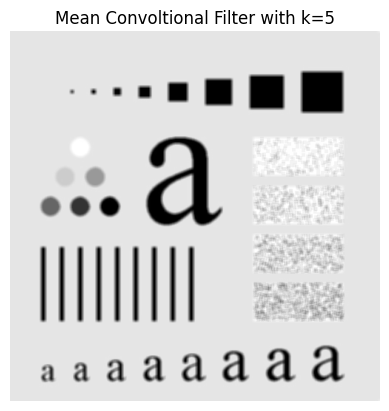

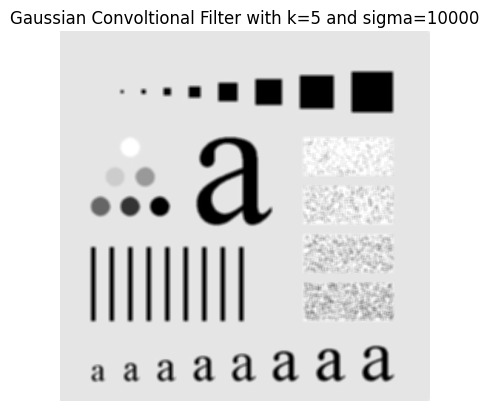

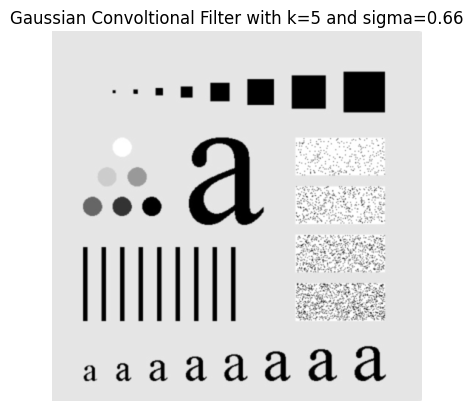

MSE between Mean Filter and Gaussian Filter with sigma=10000: 0.7141011701431809
MSE between Mean Filter and Gaussian Filter with sigma=0.66: 0.08303948288788539


In [46]:
mf = meanFilter(img1, kernel_size=5)
gf = gaussianFilter(img1, kernel_size=5, sigma=1e4)
gf1 = gaussianFilter(img1, kernel_size=5, sigma=0.66)

show_image(mf, cmap="gray", title="Mean Convoltional Filter with k=5")
show_image(gf, cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=10000")
show_image(gf1, cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=0.66")

mse1 = np.mean((mf - gf) ** 2)
mse2 = np.mean((mf - gf1) ** 2)

print("MSE between Mean Filter and Gaussian Filter with sigma=10000: {}".format(mse1))
print("MSE between Mean Filter and Gaussian Filter with sigma=0.66: {}".format(mse2))

<!-- As we can see from the above images, the image with Mean Filter looks more identical to the image with Gaussian Filter with high sigma value. This behavior occurs because a very large sigma value in the Gaussian filter results in a very broad and flat Gaussian kernel, essentially approaching a uniform or mean filter. -->
To add.

#### 2. Need for Speed

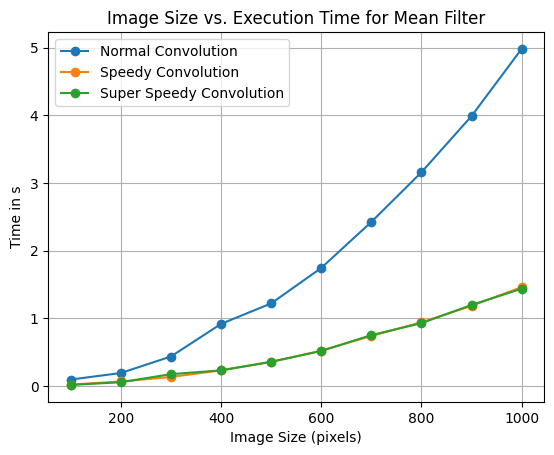

In [64]:
timings = list()
speedyTimings = list()
superSpeedyTimings = list()
image_sizes = range(100, 1100, 100)

for size in image_sizes:
    random_image = np.random.rand(size, size)

    _, timing = meanFilter(random_image, kernel_size=5, timing=True)
    timings.append(timing)

    _, timing = speedyMeanFilter(random_image, kernel_size=5, timing=True)
    speedyTimings.append(timing)

    # _, timing = superSpeedyMeanFilter(random_image, kernel_size=5, timing=True)
    # superSpeedyTimings.append(timing)

plt.plot(image_sizes, timings, marker='o', label="Normal Convolution")
plt.plot(image_sizes, speedyTimings, marker='o', label="Speedy Convolution")
# plt.plot(image_sizes, superSpeedyTimings, marker='o', label="Super Speedy Convolution")
plt.title('Image Size vs. Execution Time for Mean Filter')
plt.xlabel('Image Size (pixels)')
plt.ylabel('Time in s')
plt.grid(True)
plt.legend()
plt.show()

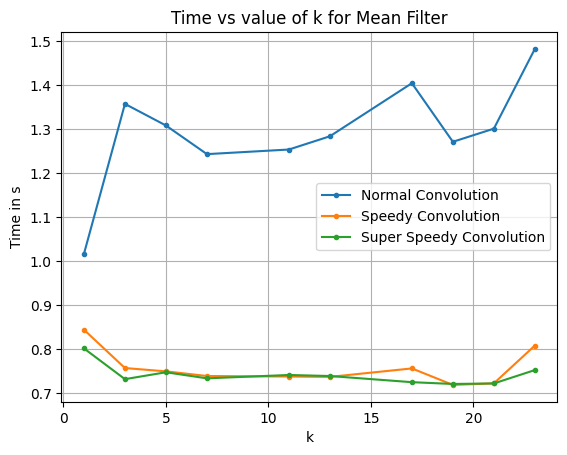

In [65]:
timings = list()
speedyTimings = list()
superSpeedyTimings = list()
ks = [1,3,5,7,11,13,17,19,21,23]

for k in ks:
    _, timing = meanFilter(img1, kernel_size=k, timing=True)
    timings.append(timing)

    _, timing = speedyMeanFilter(img1, kernel_size=k, timing=True)
    speedyTimings.append(timing)

    # _, timing = superSpeedyMeanFilter(img1, kernel_size=k, timing=True)
    # superSpeedyTimings.append(timing)

plt.plot(ks, timings, marker=".", label="Normal Convolution")
plt.plot(ks, speedyTimings, marker=".", label="Speedy Convolution")
# plt.plot(ks, superSpeedyTimings, marker=".", label="Super Speedy Convolution")
plt.xlabel("k")
plt.ylabel("Time in s")
plt.title("Time vs value of k for Mean Filter")
plt.grid(True)
plt.legend()
plt.show()